# Machine Learning Programming Exercise 2: Regularized Logistic Regression

In [1]:
#import package(s)
import numpy as np
from numpy import loadtxt
import matplotlib.pyplot as plt
import scipy.optimize as sp

## 2  Regularized Logistic Regression
In this part of the exercise, we will implement regularized logistic regression to predict whether microchips from a fabrication plant passes quality assurance (QA). During QA, each microchip goes through various tests to ensure it is functioning correctly.

Suppose a product manager of the factory has the test results for some microchips on two diﬀerent tests. From these two tests, they would like to determine whether the microchips should be accepted or rejected. To help make the decision, we have a dataset of test results on past microchips to build a logistic regression model.

### 2.1 Visualizing the data
Two classes are represented in different markers like before:  the positive ($y = 1$, accepted) and negative ($y = 0$, rejected). From the plot, there seems to be a clear separation between them. 

The dataset cannot be separated into positive and negative examples by a straight-line through the plot. Therefore, a straightforward application of logistic regression will not perform well on this dataset since logistic regression will only be able to ﬁnd a linear decision boundary.

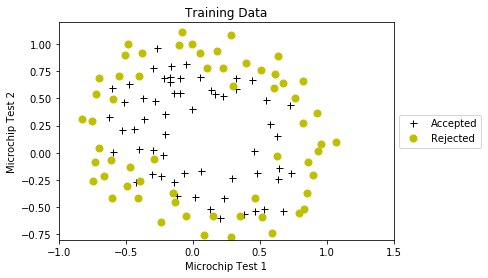

In [2]:
#define function for exercise(s)
def plotData(x,y,lab):
#PLOTDATA Plots the data points X and y into a new figure 
#   PLOTDATA(x,y) plots the data points with + for the positive examples
#   and o for the negative examples. X is assumed to be a Mx2 matrix.

    pos = y==1
    neg = y==0
    plt.figure()
    plt.plot(x[pos,0], x[pos,1], 'k+', markersize=7, label=lab[0])
    plt.plot(x[neg,0], x[neg,1], 'yo', markersize=7, label=lab[1])
    plt.legend(loc='center left', bbox_to_anchor=(1,0.5))

#Load Data
#The first two columns contains the X values and the third column
#contains the label (y).
data = loadtxt('ex2data2.txt',delimiter = ",")

X = data[:,0:2] 
#test 1 and test 2 scores
y = data[:,2]
ycol = data[:,2].reshape(data[:,2].shape[0],1)
#reshape y to be column vector
#accepted/rejected data

# PLOT DATA
plotlabels = ['Accepted', 'Rejected']
plotData(X, y, plotlabels)
#scatter plot of training data
plt.axis([-1, 1.5, -0.8, 1.2])
#adjust axes for better viewing
plt.ylabel('Microchip Test 2')
plt.xlabel('Microchip Test 1')
plt.title('Training Data')
plt.show()

### 2.2 Feature mapping
One way to ﬁt the data better is to create more features from each data point. In the function mapFeature, the features will be mapped into all polynomial terms of $x_1$ and $x_2$ up to the sixth power.

$ \begin{align*}
\text{mapFeature}(x) =
  \begin{bmatrix}
    1  \\
    x_1 \\
    x_2 \\
    x_1^2 \\
    x_1 x_2\\
    x_2^2 \\
    x_1^3 \\
    \vdots \\
    x_1 x_2^5 \\
    x_2^6 \\
  \end{bmatrix}
  \end{align*}
$

As a result of this mapping, our vector of two features (the scores on two QA tests) has been transformed into a 28-dimensional vector. A logistic regression classiﬁer trained on this higher-dimension feature vector will have a more complex decision boundary and will appear nonlinear when drawn in our 2-dimensional plot. 

While the feature mapping builds a more expressive classiﬁer, it also more susceptible to overﬁtting. In the next parts of the exercise, regularized logistic regression is used to ﬁt the data and to see how regularization can help combat the overﬁtting problem.


### 2.3 Cost function and gradient
The regularized cost function in logistic regression is
$\begin{align*} J(\theta) = \frac{1}{m} \sum_{i=1}^m \left [ -y^{(i)} \log(h_{\theta} (x^{(i)})) - (1-y^{(i)}) \log(1-h_{\theta} (x^{(i)})) \right] + \frac{\lambda}{2m} \sum_{j=1}^n \theta_j^2 \end{align*}$. Remember to not regularize the parameter $\theta_0$. This value is always a constant so regularization is not needed. 

The gradient of the cost function is a vector where the $j$th element is deﬁned as follows:
$\begin{align*} \frac{\partial J(\theta)}{\partial \theta_0} &= \frac{1}{m} \sum_{i=1}^m (h_{\theta} (x^{(i)}) -y^{(i)}) x_0^{(i)} \quad j=0 \\ \frac{\partial J(\theta)}{\partial \theta_j} &= \left ( \frac{1}{m} \sum_{i=1}^m (h_{\theta} (x^{(i)}) -y^{(i)}) x_j^{(i)} \right) + \frac{\lambda}{m} \theta_j \quad j \geq 1\end{align*}$.

Recall, that $\lambda$ is the regularization parameter. This parameter tries to prevent overfitting by aiming to fit the data well and to keep the values of the parameters small.

In [3]:
#define function for exercise(s)
def mapFeature(X1,X2):
# MAPFEATURE Feature mapping function to polynomial features
    
#   MAPFEATURE(X1, X2) maps the two input features
#   to quadratic features used in the regularization exercise.
#   Returns a new feature array with more features, comprising of 
#   X1, X2, X1.^2, X2.^2, X1*X2, X1*X2.^2, etc..
    
#   Inputs X1, X2 must be the same size
    degree = 6
    if np.ndim(X1) == 0:
        #if X1 has zero dimensions (ie a scalar) then out is a 1 by 1 array
        out = np.ones((1,1))
    else:
        #else out is a len(X1) by 1 array
        out = np.ones((len(X1),1))
        
    for i in range(1,degree+1):
        for j in range(i+1):
            feature = np.power(X1,i-j)*np.power(X2,j)
            out = np.column_stack((out, feature))
    return out

def sigmoid(z):
#SIGMOID Compute sigmoid function
#   g = SIGMOID(z) computes the sigmoid of z.
    g = 1/(1 + np.exp(-z))
    return g

def hypfunc(theta,X):
# hypothesis function: returns sigmoid(X * theta)
    X = np.matrix(X)
    theta = np.matrix(theta)
    return sigmoid(X * theta.T)

def costFunction(theta, X, y): 
#COSTFUNCTION Compute cost for logistic regression
#   J = COSTFUNCTION(theta, X, y) computes the cost of using theta as the
#   parameter for logistic regression 
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    h = hypfunc(theta,X)
    first = np.multiply(-y, np.log(h))
    second = np.multiply((1 - y), np.log(1 - h))
    return (first - second).mean()

def gradient(theta, X, y):
#GRADIENT Compute gradient for logistic regression
#   G = GRADIENT(theta, X, y) computes the gradient of the cost
#   w.r.t. to the parameters.    
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    parameters = int(theta.shape[1])
    grad = np.zeros(parameters)
    for i in range(parameters):
        term = np.multiply(hypfunc(theta,X) - y, X[:,i])
        grad[i] = term.mean()
    return grad

def costFunctionReg(theta, X, y, learningRate):  
#COSTFUNCTIONREG Compute cost for logistic regression with regularization
#   J = COSTFUNCTIONREG(theta, X, y, lambda) computes the cost of using
#   theta as the parameter for regularized logistic regression and the     
    C = costFunction(theta, X, y)
    reg = (learningRate*np.sum(np.power(theta[1:theta.shape[0]+1],2)))/(2*len(X))
    return C + reg

def gradientReg(theta, X, y, learningRate): 
#   GRADIENTREG Compute gradient for logistic regression with regularization
#   G = GRADIENTREG(theta, X, y, lambda) computes the 
#   gradient of the cost w.r.t. to the parameters.    
    G = gradient(theta, X, y)
    parameters = len(theta)
    for i in range(1,parameters):
        G[i] = G[i] + ((learningRate* theta[i])/len(X))
    return G

# =========== Part 1: Regularized Logistic Regression ============
#  In this part, you are given a dataset with data points that are not
#  linearly separable. However, you would still like to use logistic
#  regression to classify the data points.
#  To do so, you introduce more features to use -- in particular, you add
#  polynomial features to our data matrix (similar to polynomial
#  regression).

#Add Polynomial Features
#Note that mapFeature also adds a column of ones for us, so the intercept
#term is handled
X = mapFeature(X[:,0], X[:,1])

#Initialize fitting parameters
initial_theta = np.zeros((X.shape[1]))

# Set regularization parameter lambda to 1
Lambda = 1
#compute and display initial cost and gradient for regularized logistic
cost = costFunctionReg(initial_theta, X, ycol, Lambda)
print('Cost at initial theta (zeros): ', cost)
print('Expected cost (approx): 0.693\n')
grad = gradientReg(initial_theta, X, ycol, Lambda)
print('Gradient at initial theta (zeros) - first five values only:\n')
print(grad[0:5])
print('Expected gradients (approx) - first five values only:') 
print(' 0.0085\n 0.0188\n 0.0001\n 0.0503\n 0.0115\n')

#compute and display cost and gradient with all-ones theta and lambda = 10
Lambda = 10
test_theta = np.ones((X.shape[1]))
cost = costFunctionReg(test_theta, X, ycol, Lambda)
print('Cost at test theta (with lambda = 10): ', cost)
print('Expected cost (approx): 3.16\n')
grad = gradientReg(test_theta, X, ycol, Lambda)
print('Gradient at test theta - first five values only:')
print(grad[0:5])
print('Expected gradients (approx) - first five values only:') 
print(' 0.3460\n 0.1614\n 0.1948\n 0.2269\n 0.0922\n')

Cost at initial theta (zeros):  0.6931471805599454
Expected cost (approx): 0.693

Gradient at initial theta (zeros) - first five values only:

[8.47457627e-03 1.87880932e-02 7.77711864e-05 5.03446395e-02
 1.15013308e-02]
Expected gradients (approx) - first five values only:
 0.0085
 0.0188
 0.0001
 0.0503
 0.0115

Cost at test theta (with lambda = 10):  3.1645093316150095
Expected cost (approx): 3.16

Gradient at test theta - first five values only:
[0.34604507 0.16135192 0.19479576 0.22686278 0.09218568]
Expected gradients (approx) - first five values only:
 0.3460
 0.1614
 0.1948
 0.2269
 0.0922



### 2.4 Plotting the decision boundary
The function plotDecisionBoundary will plot the non-linear decision boundary by computing the classiﬁer’s predictions on an evenly spaced grid and then and draw a contour plot of where the predictions change from $y = 0$ to $y = 1$. 

This time, I am using fmin_tnc to learn the optimal parameters for $\theta$.

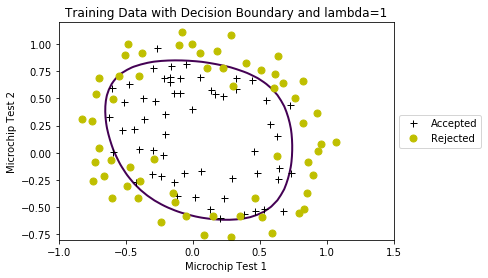

Train Accuracy:  83.05084745762711
Expected accuracy (with lambda = 1): 83.1 (approx)


In [4]:
#define function for exercise(s)
def plotDecisionBoundary(theta, X, y, lab):
#PLOTDECISIONBOUNDARY Plots the data points X and y into a new figure with
#the decision boundary defined by theta
#   PLOTDECISIONBOUNDARY(theta, X,y) plots the data points with + for the 
#   positive examples and o for the negative examples. X is assumed to be 
#   a either 
#   1) Mx3 matrix, where the first column is an all-ones column for the 
#      intercept.
#   2) MxN, N>3 matrix, where the first column is all-ones
    
    plotData(X[:,1:3], y, lab[0:2])
    
    if X.shape[1] <= 3:
        plot_x = np.array([min(X[:,1])-2, max(X[:,1])+2])
        plot_y = -(theta[1]*plot_x + theta[0])/theta[2]
        plt.plot(plot_x, plot_y, label=lab[2])
        plt.axis([30, 100, 30, 100])
    else:
        # Here is the grid range
        u = np.linspace(-1, 1.5, 50)
        v = np.linspace(-1, 1.5, 50)

        z = np.zeros((len(u), len(v)))
        # Evaluate z = theta*x over the grid
        for i in range(len(u)):
            for j in range(len(v)):
                z[i,j] = np.dot(mapFeature(u[i], v[j]),theta)
        # important to transpose z before calling contour
        z = z.T 

        # Plot z = 0
        # Notice you need to specify the range [0, 0]
        plt.contour(u, v, z, levels=[0], linewidths=2)
    
def predict(theta, X):
#PREDICT Predict whether the label is 0 or 1 using learned logistic 
#regression parameters theta
#   p = PREDICT(theta, X) computes the predictions for X using a 
#   threshold at 0.5 (i.e., if sigmoid(theta'*x) >= 0.5, predict 1)
    # Number of training examples
    m = X.shape[0] 
    p = np.zeros((m,1))
    # You need to return the following variables correctly
    h = hypfunc(theta,X)
    p[h>=0.5] = 1
    return np.matrix(p)

# ============= Part 2: Regularization and Accuracies =============
#  Optional Exercise:
#  In this part, you will get to try different values of lambda and
#  see how regularization affects the decision coundart
#  Try the following values of lambda (0, 1, 10, 100).
#  How does the decision boundary change when you vary lambda? How does
#  the training set accuracy vary?

#Initialize fitting parameters
initial_theta = np.zeros((X.shape[1]))

#Set regularization parameter lambda to 1 (you should vary this)
Lambda = 1

#Optimize
result =  sp.fmin_tnc(func=costFunctionReg, x0=initial_theta, 
                               args=(X, ycol, Lambda), fprime = gradientReg)
theta_opt = result[0]
cost_opt = costFunctionReg(theta_opt, X, ycol, Lambda)

#Plot Boundary
dblabels = ['Accepted', 'Rejected', 'Decision Boundary']
plotDecisionBoundary(theta_opt, X, y, dblabels)
#adjust axes for better viewing
plt.axis([-1, 1.5, -0.8, 1.2])
plt.ylabel('Microchip Test 2')
plt.xlabel('Microchip Test 1')
plt.title('Training Data with Decision Boundary and lambda=%s' % Lambda)
plt.show()

#compute accuracy on our training set
p = predict(theta_opt, X)
print('Train Accuracy: ', (np.mean(np.equal(p.T, y.T)))*100)
print('Expected accuracy (with lambda = 1): 83.1 (approx)')

### 2.5 Optional exercises
In this part of the exercise, diﬀerent regularization parameters for the dataset are tried out to understand how regularization prevents overﬁtting.

Notice the changes in the decision boundary as $\lambda$ varies. With a small $\lambda$, the classiﬁer gets almost every training example correct, but draws a very complicated boundary, thus overﬁtting the data. When $\lambda=0$ for the exercise the decision boundary is not good: for example, it predicts that a point at $x = (−0.25,1.5)$ is accepted $(y = 1)$, which seems to be an incorrect decision given the training set.

With a larger $\lambda$, the plot that shows an simpler decision boundary which still separates the positives and negatives fairly well. However, if $\lambda$ is set to too high a value, ﬁt is not good and the decision boundary will not follow the data so well, thus underﬁtting the data. This happens to the training data when $\lambda=100$.

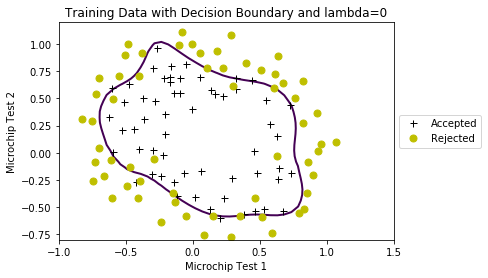

Train Accuracy:  88.13559322033898


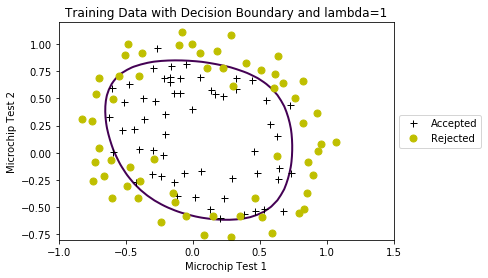

Train Accuracy:  83.05084745762711


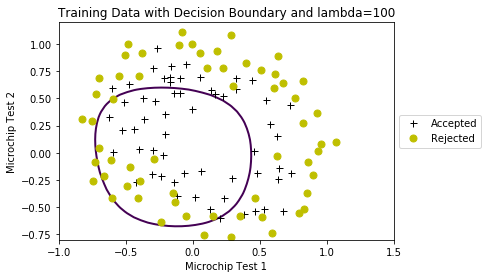

Train Accuracy:  61.016949152542374


In [5]:
Lambda = np.array([[0, 1, 100]])

for i in range(Lambda.shape[1]):
    #Optimize    
    result =  sp.fmin_tnc(func=costFunctionReg, x0=initial_theta, 
                               args=(X, ycol, Lambda[0,i]), fprime = gradientReg)
    theta_opt = result[0]
    cost_opt = costFunctionReg(theta_opt, X, ycol, Lambda[0,i])
    
    #plot boundary
    dblabels = ['Accepted', 'Rejected', 'Decision Boundary']
    plotDecisionBoundary(theta_opt, X, y, dblabels)
    #adjust axes for better viewing
    plt.axis([-1, 1.5, -0.8, 1.2])
    plt.ylabel('Microchip Test 2')
    plt.xlabel('Microchip Test 1')
    plt.title('Training Data with Decision Boundary and lambda=%s' % Lambda[0,i])
    plt.show()

    #compute accuracy on our training set
    p = predict(theta_opt, X)
    print('Train Accuracy: ', (np.mean(np.equal(p.T, y.T)))*100)